# Trabajo Practico 2 - Sistemas Complejos

In [33]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab
import math
import pandas as pd
from io import StringIO
import random

In [2]:
golden_mean = (math.sqrt(5)-1.0)/2.0       # Aesthetic ratio
fig_width = 7+3/8                          # width  in inches
fig_height = fig_width*golden_mean         # height in inches
fig_size =  [fig_width,fig_height]

params = {'backend': 'ps',
          'axes.titlesize': 18,
          'axes.labelsize': 19,
          'axes.linewidth': 0.7, 
          'axes.grid': False,
          'axes.labelweight': 'normal',  
          'font.family': 'serif',
          'font.size': 18.0,
          'font.weight': 'normal',
          'text.color': 'black',
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'text.usetex': True,
          'legend.fontsize': 16,
          'figure.dpi': 700,
          'figure.figsize': fig_size,
          'savefig.dpi': 700,
         }

pylab.rcParams.update(params)

Importacion de redes 

In [3]:
G_APMS = nx.read_edgelist('yeast_AP-MS.txt')
G_Y2H = nx.read_edgelist('yeast_Y2H.txt')
G_LIT = nx.read_edgelist('yeast_LIT.txt')

G_LIT_Reguly = nx.Graph()
data_lit_reguly = np.genfromtxt("yeast_LIT_Reguly.txt",dtype='unicode',delimiter = '\t')
yeast_LIT_Reguly_raw = [data_lit_reguly[1:,0],data_lit_reguly[1:,1]]

i=1
while i<len(data_lit_reguly[1:,0]):
    G_LIT_Reguly.add_edge(data_lit_reguly[i,0],data_lit_reguly[i,1])
    i+=1

Cargamos el archivo que contiene la esencialidad de los nodos

In [4]:
G_ESSENTIAL = nx.Graph()
data_G_ESSENTIAL = np.genfromtxt("Essential_ORFs_paperHe.txt",dtype='unicode',delimiter = '\t')
yeast_G_ESSENTIAL_raw = [data_G_ESSENTIAL[2:,1]]

i = 0
l = len(yeast_G_ESSENTIAL_raw[0][:])

while i < l:
    proteina = yeast_G_ESSENTIAL_raw[0][i]
    yeast_G_ESSENTIAL_raw[0][i] = proteina.rstrip(" ")
    i+=1

Caracteristicas basicas de la red

In [5]:
def caracteristicas_basicas(G):
    numero_nodos = G.number_of_nodes()
    numero_enlaces = G.number_of_edges()
    grado_medio = np.round(np.true_divide(numero_enlaces,numero_nodos),2)
    average_clustering_coeficient = round(nx.average_clustering(G),2)
    resultado=[numero_nodos,numero_enlaces,grado_medio,average_clustering_coeficient]
    return resultado


Procesamiento de caracteristicas basicas de todas las redes

In [6]:
resultado_apms = caracteristicas_basicas(G_APMS)
resultado_y2h = caracteristicas_basicas(G_Y2H)
resultado_lit = caracteristicas_basicas(G_LIT)
resultado_lit_reguly = caracteristicas_basicas(G_LIT_Reguly)

In [7]:
data = pd.DataFrame({" ":["AP/MS",'Y2H','LIT','LIT-Reguly'],
                     "Number of Nodes":[resultado_apms[0],resultado_y2h[0],resultado_lit[0],resultado_lit_reguly[0]],
                     "Number of Edges":[resultado_apms[1],resultado_y2h[1],resultado_lit[1],resultado_lit_reguly[1]],
                     "Average degree":[resultado_apms[2],resultado_y2h[2],resultado_lit[2],resultado_lit_reguly[2]],
                     "Average clustering coefficient":[resultado_apms[3],resultado_y2h[3],resultado_lit[3],resultado_lit_reguly[3]]
                    })
data



,,Average clustering coefficient,Average degree,Number of Edges,Number of Nodes
0,AP/MS,0.55,5.59,9070,1622
1,Y2H,0.05,1.45,2930,2018
2,LIT,0.29,1.90,2925,1536
3,LIT-Reguly,0.26,3.59,11857,3307


Superposición de dos redes

La siguiente función remueve los nodos de la primera red que no estan en la segunda red. 

In [8]:
def intersection(red1,red2):
    red_interseccion = nx.intersection(red1,red2)
    
    resultado = red_interseccion.number_of_edges()
    return resultado


In [9]:
def superposicion(red1,red2):
    copia_red1=red1.copy()
    copia_red2=red2.copy()
    
    copia_red1.remove_nodes_from(n for n in red1 if n not in red2)
    copia_red2.remove_nodes_from(n for n in red2 if n not in red1)
    
    superposicion = intersection(copia_red1,copia_red2)
    return superposicion 


In [10]:
def superposicion_redes(redes):
    i = 0
    l = len(redes)
    matriz_superposicion = np.zeros((l,l))
    while i < l:
        red_i = redes[i]
        j = i+1
        while j < l:
            red_j = redes[j]
            valor = superposicion(red_i,red_j)
            matriz_superposicion[i][j] = valor / (float(red_i.number_of_edges()))
            matriz_superposicion[j][i] = valor / (float(red_j.number_of_edges()))
            j+=1
        i+=1
        #matriz_superposicion[0][0] = APMS
        #matriz_superposicion[1][1] = Y2H
        #matriz_superposicion[2][2] = G_LIT
        #matriz_superposicion[3][3] = G_LIT_Reguly
    return matriz_superposicion

In [11]:
redes = [G_APMS,G_Y2H,G_LIT,G_LIT_Reguly]
superposicion_redes(redes)

array([[0.        , 0.02866593, 0.14310915, 0.27783903],
       [0.0887372 , 0.        , 0.0887372 , 0.16348123],
       [0.44376068, 0.08888889, 0.        , 0.97777778],
       [0.21253268, 0.04039808, 0.24120773, 0.        ]])

Creamos una función que agrega el atributo "esencialidad" al grafo G

In [12]:
def agrega_esencialidad(red,lista_esencial):
    
    j = 0
    l = len(red)
    while j < l:
        nombre = list(red)[j]
        red.node[nombre]['esencialidad']=0
        j += 1
    
    for i in lista_esencial[0]:
        if (i in red):
            red.node[i]['esencialidad']=1
    return


Le agregamos la esencialidad a cada nodo de cada una de las red

In [13]:
agrega_esencialidad(G_APMS,yeast_G_ESSENTIAL_raw)
agrega_esencialidad(G_Y2H,yeast_G_ESSENTIAL_raw)
agrega_esencialidad(G_LIT,yeast_G_ESSENTIAL_raw)
agrega_esencialidad(G_LIT_Reguly,yeast_G_ESSENTIAL_raw)

Analisis de hubs

En primer lugar calculamos la distribución de grado

In [14]:
def maximo_grado(red):
    cantidad_nodos = red.number_of_nodes()
    maximo = 0
    i=0
    while i<cantidad_nodos:
        if list(red.degree)[i][1]>maximo:
            maximo = list(red.degree)[i][1]
        i+=1
    return maximo

In [15]:
def distribucion_grado(red):
    numero_nodos = red.number_of_nodes()
    l = len(red)
    m = maximo_grado(red)
    vector_nodos_esenciales= np.zeros(m+1)
    vector_grados= np.zeros(m+1)
    i = 0
    while i < l:
        grado = list(red.degree)[i][1]
        vector_grados[grado] += 1
        
        nombre = list(red)[i]
        esencialidad_nodo = red.node[nombre]['esencialidad']
        
        if (esencialidad_nodo==1):
            vector_nodos_esenciales[grado] += 1
        i+=1
    return (vector_grados,vector_nodos_esenciales)                        
    


In [16]:
hubs_APMS = distribucion_grado(G_APMS)
hubs_Y2H = distribucion_grado(G_Y2H)
hubs_LIT = distribucion_grado(G_LIT)
hubs_LIT_Reguly = distribucion_grado(G_LIT_Reguly)

In [17]:
def hub_definition(hubs):
    vector_grados = hubs[0]
    vector_esencial = hubs[1]
    i = 1
    l = len(vector_grados)
    eje_x= np.zeros(l)
    eje_y= np.zeros(l)
    total_nodos = np.sum(vector_grados)
    while (i < l+1):
        eje_x[i-1]=np.sum(vector_grados[l-i:l])/(float(total_nodos))
        eje_y[i-1]=np.sum(vector_esencial[l-i:l])/np.sum(vector_grados[l-i:l])
        i+=1
        
    return(eje_x,eje_y)      

In [18]:
eje_x_APMS = hub_definition(hubs_APMS)[0][:]
eje_y_APMS = hub_definition(hubs_APMS)[1][:]

eje_x_Y2H = hub_definition(hubs_Y2H)[0][:]
eje_y_Y2H = hub_definition(hubs_Y2H)[1][:]

eje_x_LIT = hub_definition(hubs_LIT)[0][:]
eje_y_LIT = hub_definition(hubs_LIT)[1][:]

eje_x_LIT_Reguly = hub_definition(hubs_LIT_Reguly)[0][:]
eje_y_LIT_Reguly = hub_definition(hubs_LIT_Reguly)[1][:]

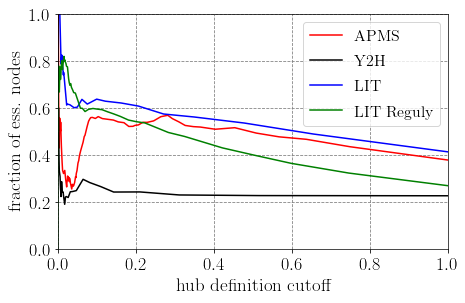

In [19]:
plt.plot(eje_x_APMS,eje_y_APMS,'-r',label='APMS')
plt.plot(eje_x_Y2H,eje_y_Y2H,'-k',label='Y2H')
plt.plot(eje_x_LIT,eje_y_LIT,'-b',label='LIT')
plt.plot(eje_x_LIT_Reguly,eje_y_LIT_Reguly,'-g',label='LIT Reguly')
pylab.xlabel('hub definition cutoff')
pylab.ylabel('fraction of ess. nodes')
plt.grid(color='gray', linestyle='--')
pylab.ylim(0, 1)
pylab.xlim(0, 1)
plt.legend()
plt.show()

In [21]:
'''
funcion_remove_random(red,umbral):
    #umbral = hasta donde llega el eje x
    copia_red
    inicilizar vectores para el grafico
    porcentaje = 0
    cantidad_maxima_nodos_removidos = umbral*cantidad_nodos
    for i=0:cantidad_maxima_nodos_removidos
        eje_x=[i/cantidad_nodos]
        copia_red = le quitamos un nodo al azar
        calculo = calcula_tamaño_comp_gigante(copia_red)/tamaño_componente_gigante_original
        
        eje_y+=[calculo]
    return(eje_x,eje_y)    
    
ListOfNodes = g.nodes()
NumberofNodes = g.number_of_nodes()
sample = 1
RandomSample = random.sample(ListOfNodes, sample)
print(ListOfNodes)
g.remove_nodes_from(RandomSample)
 
'''

'\nfuncion_remove_random(red,umbral):\n    #umbral = hasta donde llega el eje x\n    copia_red\n    inicilizar vectores para el grafico\n    porcentaje = 0\n    cantidad_maxima_nodos_removidos = umbral*cantidad_nodos\n    for i=0:cantidad_maxima_nodos_removidos\n        eje_x=[i/cantidad_nodos]\n        copia_red = le quitamos un nodo al azar\n        calculo = calcula_tama\xc3\xb1o_comp_gigante(copia_red)/tama\xc3\xb1o_componente_gigante_original\n        \n        eje_y+=[calculo]\n    return(eje_x,eje_y)    \n    \nListOfNodes = g.nodes()\nNumberofNodes = g.number_of_nodes()\nsample = 1\nRandomSample = random.sample(ListOfNodes, sample)\nprint(ListOfNodes)\ng.remove_nodes_from(RandomSample)\n \n'

In [74]:
def funcion_remove_random(red,umbral):
    copia_red = red.copy()
    size_giant_original = len(max(nx.connected_components(red),key=len))
    eje_x = []
    eje_y = []
    cantidad_nodos = copia_red.number_of_nodes()
    cantidad_maxima_nodos_removidos = int(umbral*red.number_of_nodes())
    for i in range(0,cantidad_maxima_nodos_removidos):
        ListOfNodes = copia_red.nodes()
        RandomSample = random.sample(ListOfNodes, 1)
        copia_red.remove_nodes_from(RandomSample)
        eje_x+=[i/float(cantidad_nodos)]
        cantidad_nodos_copia = copia_red.number_of_nodes()
        size_giant_copia = len(max(nx.connected_components(copia_red),key=len))
        calculo = size_giant_copia/float(cantidad_nodos_copia)    
        ## Hay que normalizarlo por la la fraccion original 
        eje_y+=[calculo]
    return(eje_x,eje_y)

In [75]:
resultado = funcion_remove_random(G_APMS,0.35)

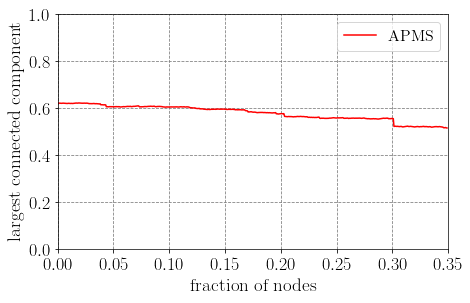

In [76]:
plt.plot(resultado[0],resultado[1],'-r',label='APMS')
pylab.xlabel('fraction of nodes')
pylab.ylabel('largest connected component')
plt.grid(color='gray', linestyle='--')
pylab.ylim(0, 1)
pylab.xlim(0, 0.35)
plt.legend()
plt.show()

In [67]:
nx.current_flow_closeness_centrality(nx.connected_components(G_APMS), weight='weight', dtype='float', solver='lu')

AttributeError: 'generator' object has no attribute 'is_directed'